Part 3: Manual Homography + Sticthing
import opencv-python version: 4.8.0
import numpy.linalg

In [2]:
import cv2 
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as  linalg


Q1. Load im01.jpg and im02.jpg. Let the user to choose 4 points on im01.jpg and 4 points on im02.jpg

In [31]:
image_1 = cv2.imread('im01.jpg')
image_2 = cv2.imread('im02.jpg')
image_1 = cv2.cvtColor(image_1, cv2.COLOR_BGR2RGB)
image_2 = cv2.cvtColor(image_2, cv2.COLOR_BGR2RGB)
print(image_1.shape, image_2.shape)

points_1=[]
points_2=[]

def coordinates_select(event, x, y, flags, param):
    """
    GUI function it will first show h1.jpg to choose 4 coordinates,
    then show h2.jpg and choose 4 corresponding coordinates pairs with h1.jpg
    each will be saved in points_1 and points_2 respectively 

    """
    global click_on_image
    if event == cv2.EVENT_LBUTTONDOWN:
        if click_on_image==1:
           points_1.append((x, y))
           cv2.circle(image_1, (x, y), 5, (0, 0, 255), -1)
           cv2.imshow('Find four points on im01.jpg', image_1)
        elif click_on_image==2:
           points_2.append((x, y))
           cv2.circle(image_2, (x, y), 5, (0, 0, 255), -1)
           cv2.imshow('Find four points on im02.jpg corresponding to points in im01.jpg', image_2)

click_on_image=1
cv2.imshow('Find four points on im01.jpg', image_1)
cv2.setMouseCallback('Find four points on im01.jpg', coordinates_select)
while len(points_1) < 4:
    cv2.waitKey(10)
cv2.destroyWindow('Find four points on im01.jpg')

click_on_image=2
cv2.imshow('Find four points on im02.jpg corresponding to points in im01.jpg', image_2)
cv2.setMouseCallback('Find four points on im02.jpg corresponding to points in im01.jpg', coordinates_select)
while len(points_2) < 4:
    cv2.waitKey(10)
cv2.destroyWindow('Find four points on im02.jpg corresponding to points in im01.jpg')


def cv2_coordinates(points_1, points_2):
    img_p1=[]
    img_p2=[]
    for (x,y),(u,v) in zip(points_1, points_2):
        img_p1.append((y,x))
        img_p2.append((v,u))
    return img_p1, img_p2
cv_points_1, cv_points_2= cv2_coordinates(points_1, points_2)
print("saved points",cv_points_1, cv_points_2)

(480, 640, 3) (480, 640, 3)
saved points [(272, 359), (388, 357), (426, 491), (280, 485)] [(296, 69), (434, 66), (455, 213), (304, 209)]


Q2. Compute the homograhy matrix, and stitch the images together using the computed homography matrix and show the result:

[[ 7.59436773e-01 -2.16977325e-01  4.24402924e+01]
 [-1.80011947e-02  4.43255495e-01  3.07692654e+02]
 [-5.72852383e-05 -8.05930795e-04  1.00000000e+00]]
584 1272 -198 307


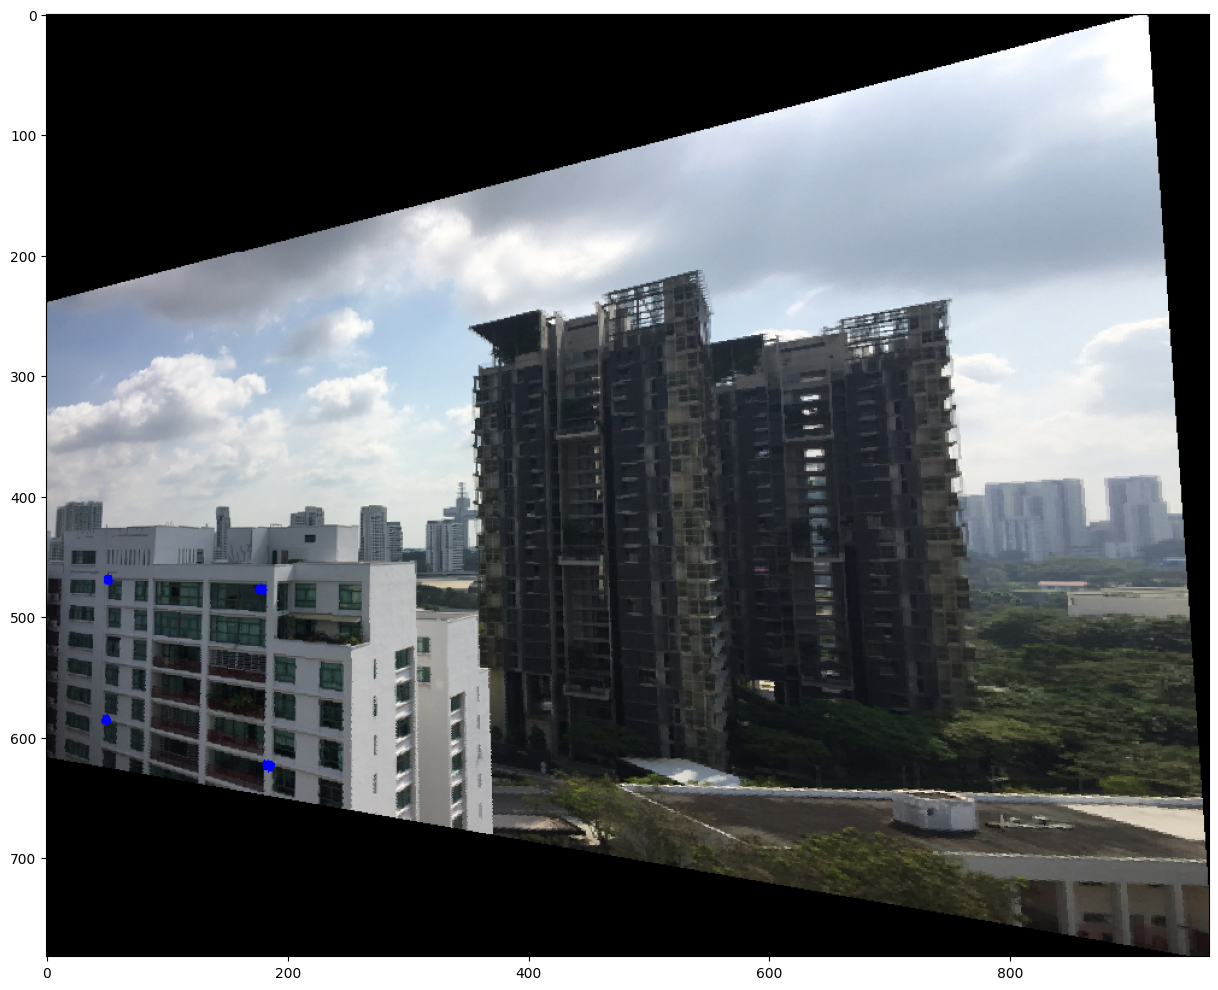

In [57]:
"""
call compute_H functions and image transformation 
"""
def compute_H(points_1, points_2, show_H):
    d=len(points_1)
    A = np.zeros([2*d, 9])
    for index ,(point_1, point_2) in enumerate(zip (points_1, points_2)):
        (x_1, y_1),(x_2,y_2)= point_1, point_2
        A[2*index, :]=[x_1, y_1,1,0,0,0,-x_2*x_1, -x_2*y_1, -x_2]
        A[2*index+1, :]=[0,0,0,x_1,y_1,1,-y_2*x_1, -y_2*y_1, -y_2]
    U, D, V= linalg.svd(A)
    H= V [-1, :].reshape(3,3)
    H = H / H[2, 2]
    if show_H is True:
        print(H)
    return H

def transform_h_2_h(h_1, h_2,cv_p1,cv_p2,show_H):
    m_list=[]
    n_list=[]
    x,y,z= h_1.shape
    u,v,w= h_2.shape
    Matrix_H= compute_H(cv_p1, cv_p2, show_H)
    corners= [(0,0),(x-1,0),(x-1,y-1),(0,y-1)]
    for corner in corners:
        m,n= corner
        temp= np.dot(Matrix_H,np.array([m, n, 1]))
        temp_m, temp_n,_ =temp/temp[2]
        m_list.append(int(temp_m))
        n_list.append(int(temp_n))
    max_u,max_v,shift_u,shift_v=int(max(m_list)), int(max(n_list)), int (min(m_list)), int(min(n_list)) 
    print(max_u,max_v,shift_u,shift_v)
    image= np.zeros([max_u-shift_u,max_v-shift_v,3],dtype=np.uint8)
    row=0
    while row<x:
        col=0
        while col < y:
            temp= np.dot(Matrix_H, np.array([row, col, 1]))
            temp_x, temp_y,_= temp/temp[2]
            if shift_u<=temp_x<max_u and shift_v<=temp_y<max_v:
                image[int(temp_x)-shift_u,int(temp_y)-shift_v,:]= h_1[int(row), int(col),:]
            col+=0.2
        row+=0.2
    return image, shift_u,shift_v

im_2_2_im_1,shift_h, shift_w= transform_h_2_h(image_2, image_1, cv_points_2, cv_points_1, show_H=True)
plt.figure(figsize=(15,15))
plt.imshow(im_2_2_im_1)

(1064, 1605, 3)


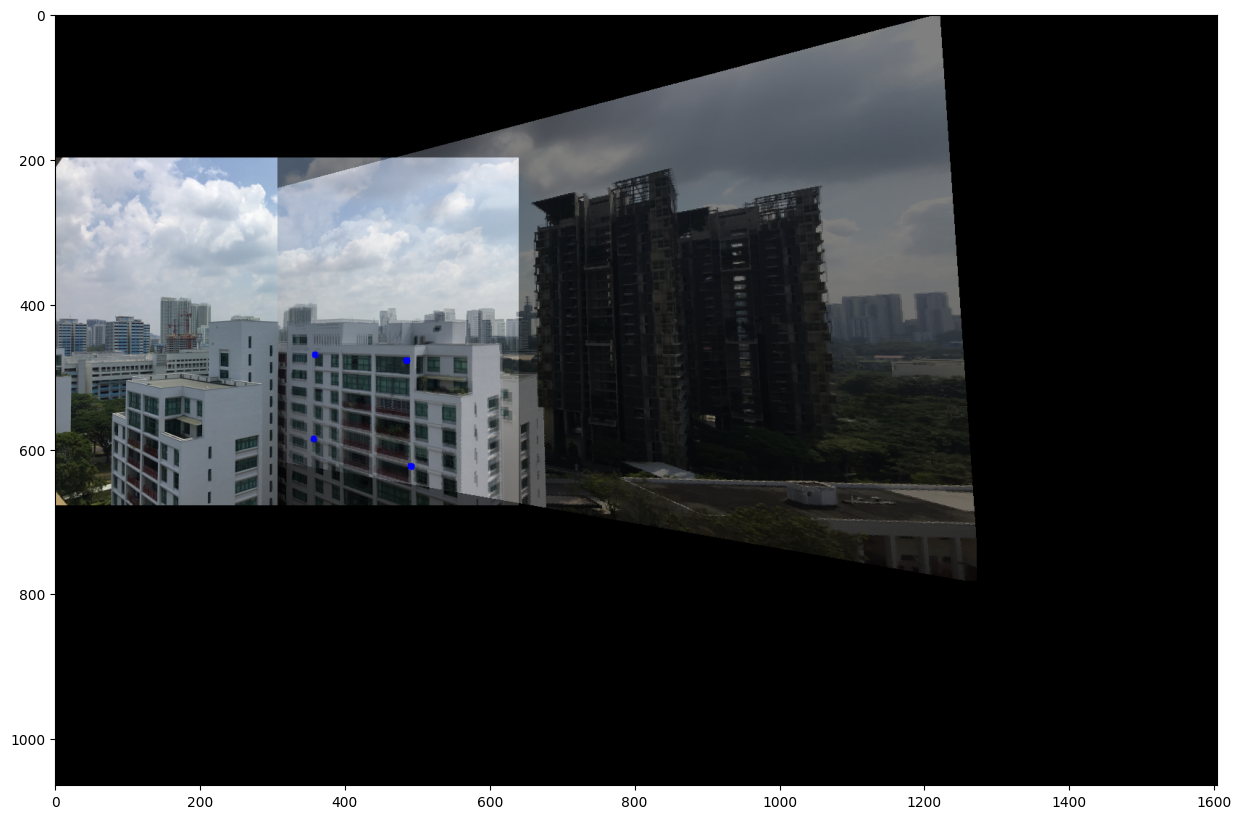

In [80]:
"""
stitching image computation both the images will be located on image_res 
"""
def stitch_image(image_1, image_stitched,shift_h, shift_w):
    h, w, _ = image_1.shape
    h_s, w_s, _=image_stitched.shape
    h_res, w_res= h-abs(shift_h)+h_s, w+w_s
    image_res = np.zeros((h_res, w_res, 3), dtype=np.uint8)
    print(image_res.shape)
    image_res[abs(shift_h):abs(shift_h)+h,:w]= image_1
    image_res[:h_s, abs(shift_w):w_s+abs(shift_w) ] = 0.5*image_stitched+0.5*image_res[:h_s, abs(shift_w):w_s+abs(shift_w)]
    return image_res
image_res=stitch_image(image_1, im_2_2_im_1, shift_h, shift_w) 
plt.figure(figsize=(15,15))
plt.imshow(image_res)

Explanation: 
The consequense of double edges in the overlapping region can be attributed to the selection of 4 matching points.
Since stitching the image is conducted by implementing two images on the same canvas with same perspective, the 4 pairs of matching points are not strictly authentic matching points. As a result, the transfered image will contain errors, when stitiching these two images, matched points will be located near the real match points, leading to the double edges of overlapped regions. 


In [7]:
cv2.destroyAllWindows()